# Sentiment Analysis of Restaurant Reviews 

In [2]:
# Handle warnings
import warnings
warnings.filterwarnings('ignore')

# Handling the data
import re
import string
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

# Data visulization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLP tools
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Models evaluation
from sklearn.metrics import confusion_matrix

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Aarthi
[nltk_data]     swami\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Aarthi
[nltk_data]     swami\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Aarthi
[nltk_data]     swami\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aarthi
[nltk_data]     swami\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load Data

In [4]:
data = pd.read_csv('Restaurant_Reviews.csv')
data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [5]:
data.tail()

,Review,Liked
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0
999,"Then, as if I hadn't wasted enough of my life ...",0


In [6]:
data.shape

(1000, 2)

In [7]:
data['Liked'] = data['Liked'].map({0:'Negative',1:'Positive'})

In [8]:
data.describe().T

,count,unique,top,freq
Review,1000,993,#NAME?,4
Liked,1000,2,Positive,500


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [10]:
data.columns

Index(['Review', 'Liked'], dtype='object')

In [11]:
# Auxiliary dictionary for text processing
mapping = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", 
           "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", 
           "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
           "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how's": "how is", 
           "I'd": "I would", "I'll": "I will", "I'm": "I am", "I've": "I have", "isn't": "is not", 
           "it's": "it is", "let's": "let us", "ma'am": "madam", "might've": "might have", "mightn't": "might not", 
           "must've": "must have", "needn't": "need not", "o'clock": "of the clock", "shan't": "shall not", 
           "she'd": "she would", "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "so've": "so have", "that's": "that is", "there's": "there is", "they'd": "they would", 
           "they're": "they are", "they've": "they have", "wasn't": "was not", "we'd": "we would", 
           "we're": "we are", "we've": "we have", "weren't": "were not", "what's": "what is", 
           "where's": "where is", "who's": "who is", "why's": "why is", "won't": "will not", 
           "wouldn't": "would not", "y'all": "you all", "you're": "you are"}

In [12]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
'not' in stop_words

False

In [13]:
# Lemmatizer for NLTK
lemmatizer = WordNetLemmatizer()

In [14]:
# Function for text preprocessing
def text_preprocessing(text, lemmatize=False):
    '''input    : the text you want to process.
       output   : the processed text '''
    
    # Remove HTML tags  
    text = BeautifulSoup(text, 'html.parser')
    text = text.get_text()
    # Lowercasing
    text = text.lower()
    # Removal of special characters, URLs, and mentions
    text = re.sub(r'http\S+|www\S+|https\S+|@[^\s]+', '', text)
    # Remove more than one space with one space
    text = re.sub(r'\s+', ' ', text)
    # Remove more than one dot by one dot
    text = re.sub(r'\.{2,}', '.', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenization
    words = word_tokenize(text)
    # Replace contractions using the mapping dictionary
    words = [mapping[word] if word in mapping else word for word in words]
    # Remove punctuation and stopwords
    words = [word for word in words if word not in string.punctuation]
    words = [word for word in words if word not in stop_words]

    # Optionally lemmatize
    if lemmatize:
        
        # Using nltk lemmatizer:
        words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [15]:
# Test preprocessing on first review
print('Original :', data.Review.iloc[0])
print('Processed text :', text_preprocessing(data.Review.iloc[0], lemmatize=True))

Original : Wow... Loved this place.
Processed text : wow loved place


In [16]:
# Apply the preprocessing function to all reviews
data['Processed_text'] = data['Review'].apply(lambda x: text_preprocessing(str(x), lemmatize=True))

In [17]:
data.head(10)

,Review,Liked,Processed_text
0,Wow... Loved this place.,Positive,wow loved place
1,Crust is not good.,Negative,crust not good
2,Not tasty and the texture was just nasty.,Negative,not tasty texture nasty
3,Stopped by during the late May bank holiday of...,Positive,stopped late may bank holiday rick steve recom...
4,The selection on the menu was great and so wer...,Positive,selection menu great price
5,Now I am getting angry and I want my damn pho.,Negative,getting angry want damn pho
6,Honeslty it didn't taste THAT fresh.),Negative,honeslty n't taste fresh
7,The potatoes were like rubber and you could te...,Negative,potato like rubber could tell made ahead time ...
8,The fries were great too.,Positive,fry great
9,A great touch.,Positive,great touch


In [18]:
data.nunique()

Review            993
Liked               2
Processed_text    988
dtype: int64

In [19]:
data.duplicated().sum()

6

In [20]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

## Generate Word Clouds

In [21]:
# Function to generate word cloud
def generate_wordcloud(text, bg_color, title='Word Cloud'):
    '''
    input : Text ,Back-ground color and Title
    output : Word cloud of most common words with your preferred title and background color
    '''
    wordcloud = WordCloud(background_color=bg_color, stopwords=set(stopwords.words('english'))).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

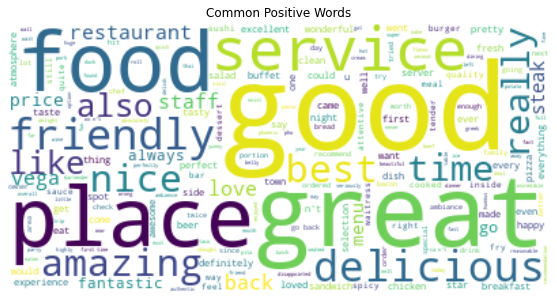

In [22]:
generate_wordcloud(" ".join(data[data['Liked']=='Positive']['Processed_text']),bg_color='white',title='Common Positive Words')

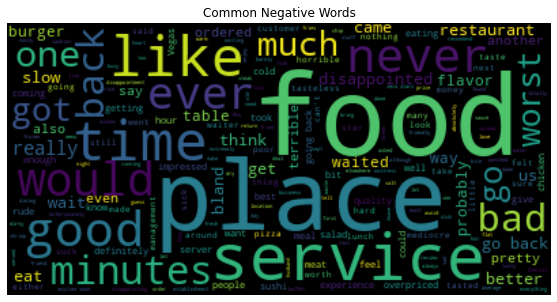

In [23]:
generate_wordcloud(" ".join(data[data['Liked']=='Negative']['Review']),bg_color='black',title='Common Negative Words')

## Visualize Sentiment Distribution 

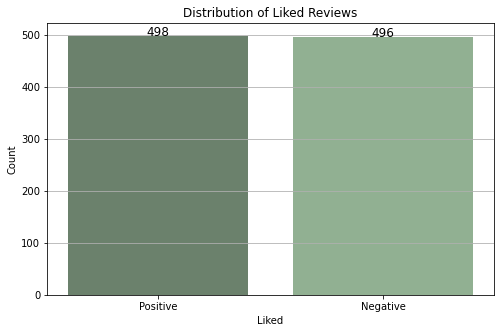

In [24]:
## Bar plot
import matplotlib.pyplot as plt
liked_counts = data['Liked'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(liked_counts.index, liked_counts.values, color=['#6B816C', '#91B092'])
plt.title('Distribution of Liked Reviews')
plt.xlabel('Liked')
plt.ylabel('Count')

# Add counts on bars
for i, count in enumerate(liked_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=12)

plt.grid(axis='y')
plt.show()


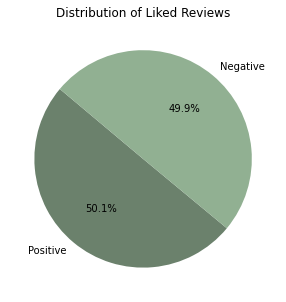

In [25]:
#pie Chart
liked_counts = data['Liked'].value_counts()

plt.figure(figsize=(8, 5))
plt.pie(liked_counts, labels=liked_counts.index, colors=['#6B816C', '#91B092'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Liked Reviews')

plt.show()


In [26]:
data['words_len'] = data['Review'].apply(lambda x : len(x.split()))
data.head()

,Review,Liked,Processed_text,words_len
0,Wow... Loved this place.,Positive,wow loved place,4
1,Crust is not good.,Negative,crust not good,4
2,Not tasty and the texture was just nasty.,Negative,not tasty texture nasty,8
3,Stopped by during the late May bank holiday of...,Positive,stopped late may bank holiday rick steve recom...,15
4,The selection on the menu was great and so wer...,Positive,selection menu great price,12


In [27]:
data['Review_len'] = data['Review'].apply(lambda x :len(x))
data.head()

,Review,Liked,Processed_text,words_len,Review_len
0,Wow... Loved this place.,Positive,wow loved place,4,24
1,Crust is not good.,Negative,crust not good,4,18
2,Not tasty and the texture was just nasty.,Negative,not tasty texture nasty,8,41
3,Stopped by during the late May bank holiday of...,Positive,stopped late may bank holiday rick steve recom...,15,87
4,The selection on the menu was great and so wer...,Positive,selection menu great price,12,59


In [28]:
data['Liked'] = data['Liked'].map({'Positive':1,'Negative':0})
data.head()

,Review,Liked,Processed_text,words_len,Review_len
0,Wow... Loved this place.,1,wow loved place,4,24
1,Crust is not good.,0,crust not good,4,18
2,Not tasty and the texture was just nasty.,0,not tasty texture nasty,8,41
3,Stopped by during the late May bank holiday of...,1,stopped late may bank holiday rick steve recom...,15,87
4,The selection on the menu was great and so wer...,1,selection menu great price,12,59


## Separate features and target variable

In [29]:
X = data['Processed_text']
y = data ['Liked']

In [30]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)

In [31]:
print('x train shape : ',x_train.shape)
print('x test shape : ',x_test.shape)
print('y train shape : ',y_train.shape)
print('y test shape : ',y_test.shape)

x train shape :  (795,)
x test shape :  (199,)
y train shape :  (795,)
y test shape :  (199,)


In [32]:
# Feature extraction using Bag of Words (BoW)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)


## Naive Bayes Classifier

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

naive_bayes =MultinomialNB()
naive_bayes.fit(X_train,y_train)
y_pred = naive_bayes.predict(X_test)

print("naive bayes Classifier training score :",naive_bayes.score(X_train,y_train))
print("naive bayes Classifier testing score :",naive_bayes.score(X_test,y_test))

naive_bayes_test_score =  round(naive_bayes.score(X_test, y_test) * 100, 2)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))


naive bayes Classifier training score : 0.949685534591195
naive bayes Classifier testing score : 0.7587939698492462
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76       100
           1       0.76      0.76      0.76        99

    accuracy                           0.76       199
   macro avg       0.76      0.76      0.76       199
weighted avg       0.76      0.76      0.76       199



## Support Vector Machine (SVM) Classifier

In [34]:
from sklearn.svm import SVC

svm = SVC(random_state=50)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Classifier training score:", svm.score(X_train, y_train))
print("SVM Classifier testing score:", svm.score(X_test, y_test))

svm_test_score =  round(svm.score(X_test, y_test) * 100, 2)

# Generate classification report
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Classifier training score: 0.979874213836478
SVM Classifier testing score: 0.7939698492462312
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.90      0.81       100
           1       0.87      0.69      0.77        99

    accuracy                           0.79       199
   macro avg       0.81      0.79      0.79       199
weighted avg       0.81      0.79      0.79       199



## Logistic Regression Classifier

In [35]:
from sklearn.linear_model import LogisticRegression

LR=LogisticRegression()
LR.fit(X_train,y_train)
y_pred_lr = LR.predict(X_test)

print("LR Classifier training score :",LR.score(X_train,y_train))
print("LR Classifier testing score :",LR.score(X_test,y_test))

lR_test_score =  round(LR.score(X_test, y_test) * 100, 2)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


LR Classifier training score : 0.9748427672955975
LR Classifier testing score : 0.7889447236180904
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80       100
           1       0.83      0.73      0.77        99

    accuracy                           0.79       199
   macro avg       0.79      0.79      0.79       199
weighted avg       0.79      0.79      0.79       199



In [36]:
models = pd.DataFrame({
    'Model': ['Naive bayes', 'SupportVectorMachine', 'LogisticRegression'],
    'Score': [naive_bayes_test_score, svm_test_score, lR_test_score ]})

models = models.sort_values(by='Score', ascending=False)
models.style.background_gradient(cmap='Blues')

,Model,Score
1,SupportVectorMachine,79.400000
2,LogisticRegression,78.890000
0,Naive bayes,75.880000


In [37]:
# Make predictions and model evaluation
naive_bayes_prediction = naive_bayes.predict(X_test)
SVM_prediction = svm.predict(X_test)
LR_prediction = LR.predict(X_test)

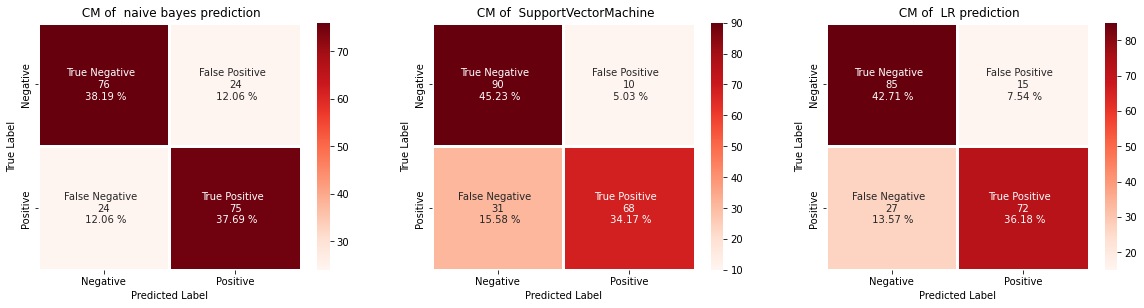

In [38]:
models_predictions=[naive_bayes_prediction,SVM_prediction,LR_prediction]
model=['naive bayes prediction','SupportVectorMachine','LR prediction']
cm_names = ['True Negative' ,'False Positive','False Negative' ,'True Positive']


plt.figure(figsize=(20,10))
for i,y_pred in enumerate(models_predictions,1) :
    
    cm=confusion_matrix(y_test,y_pred)
    value_count = [ value  for value in cm.flatten()]
    presentage = [value for value in  cm.flatten()/ np.sum(cm)  ]
    all_labels = [f'{v1}  \n{v2}\n {v3*100:.2f} %' for v1 ,v2 ,v3 in zip(cm_names ,value_count,presentage )]
    all_labels = np.asarray(all_labels).reshape(2,2)
    plt.subplot(2,3,i)
    sns.heatmap(cm,annot=all_labels,cmap='Reds',
                linewidth=3,fmt='',xticklabels=['Negative','Positive'],
                yticklabels=['Negative','Positive']
               )
    
    
    plt.title(' CM of  '+ model[i-1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

## Analyzing sentiment of text using VADER Sentiment Intensity Analyze

In [39]:
vader = SentimentIntensityAnalyzer()

def sent_analysis(text):
    '''
    input : The text
    output : The sentiment of the text
    '''
    sentiment = vader.polarity_scores(text)
    compound_score = sentiment['compound']
    
    if compound_score > 0 :
        return 1
    else:
        return 0

In [40]:
data['vader_sent'] = data['Review'].apply(lambda x : sent_analysis(x))

In [41]:
# Test the function with sample text
test_text = "I love this food!"
print(sent_analysis(test_text))  

1


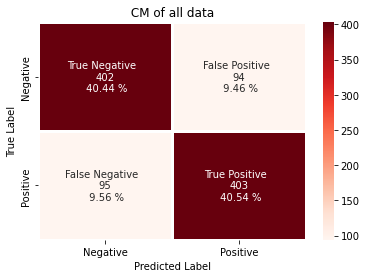

In [42]:
cm_names = ['True Negative' ,'False Positive','False Negative' ,'True Positive']
cm=confusion_matrix(data['Liked'],data['vader_sent'])
value_count = [ value  for value in cm.flatten()]
presentage = [value for value in  cm.flatten()/ np.sum(cm)  ]
all_labels = [f'{v1}  \n{v2}\n {v3*100:.2f} %' for v1 ,v2 ,v3 in zip(cm_names ,value_count,presentage )]
all_labels = np.asarray(all_labels).reshape(2,2)
sns.heatmap(cm,annot=all_labels,cmap='Reds',
                linewidth=3,fmt='',
                xticklabels=['Negative','Positive'],
                yticklabels=['Negative','Positive']
               )
    
    
plt.title(' CM of all data ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()